In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12784697904806981054
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14716652362345803764
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1094621602032788440
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15790676378
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 8204418048565218204
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:89:00.0, compute capability: 7.0"
]


In [2]:
import os

import tensorflow
#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# prerequisites
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses #objectives no longer supported, losses has replaced it

from tensorflow.keras.utils import to_categorical
from scipy.stats import norm
from tensorflow.keras import optimizers


In [3]:

import warnings
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import concatenate as concat
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate,Reshape,Flatten
from tensorflow.keras.layers import Reshape,UpSampling3D,RepeatVector,Conv3D,MaxPool3D
import tensorflow.keras
tensorflow.keras.backend.set_image_data_format('channels_first')

warnings.filterwarnings('ignore')


In [4]:
from scipy import ndimage

In [5]:
import random
import itertools

import numpy as np
from tensorflow.keras.utils import Sequence

#these are all chosen to make the overall distrubtion roughly unit gaussian... 
def density_transform(x):
    return np.log10(3*x)

def velocity_transform(x):
    return x/75.0

def temp_transform(x):
    return (3.82-np.log10(x.clip(max=1000000))*3.8) +10


def inv_density_transform(y):
    return np.power(10,4*y)/3.0

def inv_temp_transform(y):
    prefac = ((4*y-13.8))/3.8
    return np.power(10,prefac)

class DataGenerator(Sequence):
    """Generates data for Keras
    Sequence based data generator. Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs_x,list_IDs_y, normy = True,
                 to_fit=True, batch_size=32, 
                 n_channels=1, shuffle=True, inde = [0,1,2],
                 max_num = 10, fix_direction=False):
        """Initialization
        :param list_IDs: list of all 'label' ids to use in the generator
        :param labels: list of image labels (file names)
        :param image_path: path to images location
        
        :param to_fit: True to return X and y, False to return X only (I think always should be true?)
        :param batch_size: batch size at each iteration
        :param n_channels: number of image channels (should be 1)
        :param shuffle: True to shuffle label indexes after every epoch
        """
        self.list_IDs_x = list_IDs_x #filenames of density fields
        self.list_IDs_y = list_IDs_y #filenames of hydro fields
        self.max_num = max_num #maximum number of files to use per epoch
        self.normy = normy #normalize hydrofield quantities (y/n)?
        self.to_fit = to_fit #always True? False not implemented well...
        self.batch_size = batch_size 
        self.n_channels = n_channels #should always be one
        self.shuffle = shuffle #shuffle order of boxes
        self.st = "ijk" #for using various reflection symmetries 
        self.max = self.__len__()
        self.n = 0 #intializing get_item for random rearrangemnt
        self.fix_direction = fix_direction #use mirror/reflection symmetries
        self.perm = list(itertools.permutations(inde))
        
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        self.on_epoch_end()
        return int(np.floor(len(self.list_IDs_x) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        #choose random permulation
        
        #Choose orientation...
        y = self.y[self.batch_size*index:self.batch_size*(index+1)]
        X  = self.X[self.batch_size*index:self.batch_size*(index+1)]
        if self.fix_direction:
            ore = (0,1,2)
        else:
            ore = random.choice(self.perm)
            #print(ore)
     #   ore = (0, 1, 2)
        #print(ore)
        # Generate data
        #X = self._perm_x(X,ore)
        X = np.nan_to_num(X)
        if self.to_fit:
            #print(y.shape)
            #y = self._perm_y(y,ore)
            y = y
            if self.normy:
                y = np.nan_to_num(self._norm(y[:,[0,1,4],:,:]))
            else:
                y = np.nan_to_num(y[:,[0,1,4],:,:])
            return [y,y*(1+np.random.randn(2,3,32,32,32)*0)],y #changed from 32,1,1,1,1


    def _perm_x(self,hold,i):
        #for mirror/reflection symmetries
        Q = self.st[i[0]]+self.st[i[1]]+self.st[i[2]]
       
        t1_x_temp = np.einsum('mnijk->mn'+Q, hold)
        t1_x_temp[:,[0,1, 2,3,4],:,:,:] = t1_x_temp[:,[0,i[0]+1,i[1]+1,i[2]+1,4],:,:,:]
        return t1_x_temp
    
    def _perm_y(self,hold,i):
        #for mirror/reflection symmetries

        Q = self.st[i[0]]+self.st[i[1]]+self.st[i[2]]


        t1_y_temp = np.einsum('mnijk->mn'+Q, hold)
        t1_y_temp[:,[0,1, 2,3,4],:,:,:] = t1_y_temp[:,[0,i[0]+1,i[1]+1,i[2]+1,4],:,:,:]
        return t1_y_temp

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs_x))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
                # Generate indexes of the batch
        print(self.indexes)
        indexes = self.indexes[0:self.max_num]

        # Find list of IDs
        list_IDs_tempx = [self.list_IDs_x[k] for k in indexes]
        list_IDs_tempy = [self.list_IDs_y[k] for k in indexes]
        print(list_IDs_tempx)
        self.X = self._generate_X(list_IDs_tempx)
        self.y = self._generate_y(list_IDs_tempy)

            
    def _generate_X(self, list_IDs_temp_x):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        test_x = []
        for i in list_IDs_temp_x:
            test_x.append([np.load(i)])
       
        test_x = np.reshape(np.array(test_x),(-1,8,32,32,32))[:,[0,1,4],:,:,:] #changed from 64^3, 5
        return test_x

    def _generate_y(self, list_IDs_temp_y):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        test_y = []
        for i in list_IDs_temp_y:
            test_y.append([np.load(i)[:,:,:,:]])
        test_y = np.reshape(np.array(test_y),(-1,8,32,32,32)) #changed from  5,64^3
                            
        test_yn = test_y[:,:,:,:] #selecting only one baryon velocity
        return test_yn
#reducing variance so all variables have similar dynamic range: otherwise loss will be ->inf :'()'

    def _norm(self,test_yn):
        #if normed = True
            
            #test_yn[:,0] = ndimage.gaussian_filter(test_yn[:,0],0.0)
            #test_yn[:,1] = ndimage.gaussian_filter(test_yn[:,1],0.0)
            #test_yn[:,2] = ndimage.gaussian_filter(test_yn[:,2],0.0)
            
            
            test_yn[:,0] = np.log10(test_yn[:,0].clip(min=0.00001,max=10000))#density_transform(test_yn[:,0].clip(min=0.00001))/4
            test_yn[:,1] = test_yn[:,1]/100#velocity_transform(test_yn[:,1])/4
            test_yn[:,2] = np.log10(test_yn[:,2].clip(min=0.00001,max=400000))#temp_transform(test_yn[:,2].clip(min=0.00001)).clip(max=3.0)/4
            
            
            return test_yn
        
    def __next__(self):
        if self.n >= self.max:
            self.n = 0
        result = self.__getitem__(self.n)
        self.n += 1
        return result

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Conv3D,Flatten,Conv3DTranspose,concatenate
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate,Reshape,Flatten
from tensorflow.keras.layers import Reshape,UpSampling3D,RepeatVector,Conv3D,MaxPool3D, AvgPool3D
from tensorflow.keras.layers import Dropout, BatchNormalization
import tensorflow.keras


class HyPhy:
    
    """
    Class that holds the model for both train (cvae, and associated loss) and generation (gen),
    
    Currently takes as input just number of hidden dimensions and n_hidden, could 
    easily make more things free parameters to set...
    
    Set up slightly strangly to allow (hopefully) seamless switching between training and 
    generation, as well as changing generation size...
    
    """
    def __init__(self, n_hidden=128,z_dim=27, edge_clip=10, rec_loss_factor = 1):
        self.n_hidden = n_hidden #size of dense layers used to set mu, logvar for latent space
        self.z_dim = z_dim #number of latent space dimensions
        self.edge_clip = edge_clip #pixels to clip off of reconstructed tau for comparison
        self.rec_loss_factor = rec_loss_factor #relative weight of kl loss vs. rec loss
        self._init = 'lecun_normal'

        self.__init_encoder__() #initialize encoder layers
        self.__init_decoder__() #initialize decoder layers
        
        self.__init_cvae__() #creates training model
        #self.__init_gen__() #just call HyPhy.gen(), not made by default
    def __init_encoder__(self):
        ## dm
     
        self.inter_up0 = Conv3D(4,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.inter_up0p = Conv3D(5,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_dm1 = Conv3D(6,2,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_dm1p = Conv3D(6,3,padding="same",activation="selu",kernel_initializer = self._init)

        self.encode_dm2 = Conv3D(8,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_dm3 = Conv3D(20,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_dm3p = Conv3D(30,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_dm4 = Conv3D(30,2,padding="same",activation="selu",kernel_initializer = self._init) ## linear?
        self.encode_dm4p = Conv3D(30,2,padding="same",activation="selu",kernel_initializer = self._init) ## linear?

        ## tau
    
        self.encode_tau1 = Conv3D(3,2,padding="same") 
        self.encode_tau1P = Conv3D(4,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_tau2 = Conv3D(6,4,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_tau2P = Conv3D(8,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_tau3 = Conv3D(20,5,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_tau3P = Conv3D(30,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_tau4 = Conv3D(30,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.encode_tau4p = Conv3D(30,3,padding="same",activation="selu",kernel_initializer = self._init)
    def __init_decoder__(self):
        
        self.z_decoder2 = Conv3DTranspose(16,6,padding="same",activation="selu",kernel_initializer = self._init)#Dense(n_hidden*3, activation='relu')
        self.z_decoder2p = Conv3D(16,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.z_decoder3 = Conv3DTranspose(28,3,padding="same",activation="selu",kernel_initializer = self._init)
        self.z_decoder3_mix = Conv3DTranspose(28,1,padding="same",activation="selu",kernel_initializer = self._init)
        self.z_decoder3P = Conv3D(28,2,padding="same",activation="selu",kernel_initializer = self._init)
        self.z_decoder4 = Conv3DTranspose(24,1,padding="same",activation="selu",kernel_initializer = self._init)#Dense(n_hidden*2, activation='linear')
        self.z_decoder4P = Conv3D(24,2,padding="same",activation="selu",kernel_initializer = self._init)#Dense(n_hidden*2, activation='linear')

        self.y_decoder = Conv3D(24,1,padding="same",activation="selu",kernel_initializer = self._init)#Dense(x_tr.shape[1], activation='linear')
       # self.y_decoder_BN = BatchNormalization()
        self.y_decoderP1 = Conv3D(8,5,padding="same",activation="selu",kernel_initializer = self._init)#Dense(x_tr.shape[1], activation='linear')
        self.y_decoderP2 = Conv3D(8,3,padding="same",activation="selu",kernel_initializer = self._init)#Dense(x_tr.shape[1], activation='linear')
        self.y_decoderP2_mix = Conv3D(8,2,padding="same",activation="selu",kernel_initializer = self._init)#Dense(x_tr.shape[1], activation='linear')
        self.y_decoderP3 = Conv3D(8,3,padding="same",activation="tanh")#Dense(x_tr.shape[1], activation='linear')
        self.y_decoderP4 = Conv3D(3,3,padding="same",activation="selu",kernel_initializer = self._init)#Dense(x_tr.shape[1], activation='linear')
    
    def encoder_dm(self,dm_box):
        
        #getting dm field to same size as tau field...
        dm0 = dm_box#UpSampling3D(name="dm_up1")(dm_box)
        dm0 = self.inter_up0(dm0)
        dm0 = self.inter_up0p(dm0)
        #dm0 = UpSampling3D(name="dm_up2")(dm0)
        
        #step one
        dm1 = self.encode_dm1(dm0)
        dm1 = self.encode_dm1p(dm1)
        dm1_p = MaxPool3D()(dm1)

        #step two
        dm2 = self.encode_dm2(dm1_p)
        dm2_p = MaxPool3D()(dm2)
      
        #step three
        dm3 = self.encode_dm3(dm2_p)
        dm3 = self.encode_dm3p(dm3)

        dm3_p = MaxPool3D()(dm3)

        #step four
        dm4 = self.encode_dm4(dm3_p)
        dm4 = self.encode_dm4p(dm4)

        dm4 = MaxPool3D()(dm4)
        return dm0,dm1,dm2,dm3,dm4
    
    def encoder_tau(self,x_in,dm0,dm1,dm2,dm3,dm4):
        
        tau_box = Reshape((3,32,32,32))(x_in) #changed from 64^3 to 32^3

        #step 1
        tau1 = self.encode_tau1(tau_box)
        tau1 = self.encode_tau1P(tau1)

        #merge + step 2
        tau1_dm1 = concatenate([dm1,tau1],axis=1)
        tau2 = self.encode_tau2(tau1_dm1)
        tau2 = self.encode_tau2P(tau2)
        tau2_p = MaxPool3D()(tau2)

        #merge + step 3

        tau2_dm2 = concatenate([dm2,tau2_p],axis=1)
        tau3 = self.encode_tau3(tau2_dm2)
        tau3 = self.encode_tau3P(tau3)
        tau3 = BatchNormalization()(tau3)
        tau3_p = MaxPool3D()(tau3)

        #merge + step 4
        tau3_dm3 = concatenate([dm3,tau3_p],axis=1)
        tau4 = self.encode_tau4(tau3_dm3)
        tau4 = MaxPool3D()(tau4) #maybe do something else here? more layers?
       # tau4 = self.encode_tau4p(tau4)
        tau4 = MaxPool3D()(tau4)
        return tau4
        
    def variational_block(self,tau4,dm4):
        
        x_encoded = concatenate([tau4,dm4])
        x_encoded = Flatten()(x_encoded)
        x_encoded = Dense(self.n_hidden, activation='selu',kernel_initializer = self._init)(x_encoded)
        x_encoded = Dropout(.10)(x_encoded)
        x_encoded = Dense(self.n_hidden//2, activation='selu',kernel_initializer = self._init)(x_encoded)
        
        self.mu = Dense(self.z_dim, activation='linear')(x_encoded)
        self.log_var = Dense(self.z_dim, activation='linear')(x_encoded)
        
        def sampling(args):
            mu, log_var = args
            eps = K.random_normal(shape=(K.shape(dm4)[0], self.z_dim), mean=0., stddev=1.0)
            return mu + K.exp(log_var/2.) * eps

        z = Lambda(sampling, output_shape=(self.z_dim,))([self.mu, self.log_var])
        return z
    
    def decoder(self,z_new, dm0,dm1,dm2,dm3,dm4):
            
        #dm4_new = Reshape((10,4,4,4))(dm4)

        z_cond = concatenate([z_new, dm4],axis=1)
    
        z_decoded = self.z_decoder2(z_cond)
        z_decoded = UpSampling3D()(z_decoded)
        z_decoded = self.z_decoder2p(z_decoded)
        z_decoded = UpSampling3D()(z_decoded)

        z_decoded = concatenate([z_decoded,dm3],axis=1)
        z_decoded = self.z_decoder3(z_decoded)
        z_decoder = self.z_decoder3_mix(z_decoded)
        z_decoded = self.z_decoder3P(z_decoded)
        z_decoded = UpSampling3D()(z_decoded)

        z_decoded = concatenate([z_decoded,dm2],axis=1)

        z_decoded = self.z_decoder4(z_decoded)
        z_decoded = self.z_decoder4P(z_decoded)

        z_decoded = UpSampling3D()(z_decoded)

        z_decoded = concatenate([z_decoded,dm1],axis=1)

        y0 = self.y_decoder(z_decoded)
       # y0 = self.y_decoder_BN(y0)
        z_decoded = concatenate([y0,dm0],axis=1)
        y0 = self.y_decoderP1(y0)
        y0 = self.y_decoderP2(y0)
        y0 = self.y_decoderP2_mix(y0)
        y0 = self.y_decoderP3(y0)
        y = self.y_decoderP4(y0)
        return y
    
    def __init_cvae__(self):
        
        self.condition = Input(shape=(3,32,32,32),name="DM_field") #changed from 64
        #dm density, dm velocity, redshiftt
        self.x_in = Input(shape=(3,32,32,32),name="tau_field") #changed from 64
        #baryon density, los velocity, temperature
        dm_box = Reshape((3,32,32,32))(self.condition) #changed from 64

        dm0,dm1,dm2,dm3,dm4 = self.encoder_dm(dm_box)
        tau4 = self.encoder_tau(self.x_in,dm0,dm1,dm2,dm3,dm4)
        
        z = self.variational_block(tau4,dm4)
        
        z_new = Lambda(lambda x: tf.tensordot(x, K.ones((2,2,2)), axes=0))(z) #changed from 4,4,4
        
        y = self.decoder(z_new, dm0,dm1,dm2,dm3,dm4)
        
        self.cvae = Model([self.x_in, self.condition], y)
    
    def cvae_loss(self,x,y):
        ec = int(self.edge_clip)
        x_f = K.flatten(x[:,:,ec:-1*ec,ec:-1*ec,ec:-1*ec])
        y_f = K.flatten(y[:,:,ec:-1*ec,ec:-1*ec,ec:-1*ec])

        reconstruction_loss = losses.mean_squared_error(x_f, y_f)*16**3*4**3*self.rec_loss_factor
        kl_loss = 0.5 * K.sum(K.square(self.mu) + K.exp(self.log_var) - self.log_var - 1, axis = -1)
        loss = K.mean(reconstruction_loss + kl_loss)
        return loss #changed from objectives
    
    def kl_loss(self,x,y):
        # just for debugging
        ec = int(self.edge_clip)
        x_f = K.flatten(x[:,:,ec:-1*ec,ec:-1*ec,ec:-1*ec])
        y_f = K.flatten(y[:,:,ec:-1*ec,ec:-1*ec,ec:-1*ec])
        kl_loss = 0.5 * K.sum(K.square(self.mu) + K.exp(self.log_var) - self.log_var - 1, axis = -1)
        return kl_loss
    
    def rec_loss(self,x,y):    
    
        ec = int(self.edge_clip)
        x_f = K.flatten(x[:,:,ec:-1*ec,ec:-1*ec,ec:-1*ec])
        y_f = K.flatten(y[:,:,ec:-1*ec,ec:-1*ec,ec:-1*ec])

        reconstruction_loss = losses.mean_squared_error(x_f, y_f)*16**3*4**3*self.rec_loss_factor
        return reconstruction_loss #changed from objectives
    
    def generator(self,size1 = 32,reduced_len=8):
        
        _condition = Input(shape=(3,size1,size1,size1),name="DM_field")
        _z = Input(shape=(self.z_dim,))
        #x_in = Input(shape=(3,64,64,64),name="tau_field")
        
        dm0,dm1,dm2,dm3,dm4 = self.encoder_dm(_condition)
        
        _z_new = Lambda(lambda x: tf.tensordot(x, K.ones((reduced_len,reduced_len,reduced_len)), axes=0))(_z)
        
        _y = self.decoder(_z_new, dm0,dm1,dm2,dm3,dm4)
        
        self.gen = Model([_condition,_z], _y)

In [7]:
import glob
listEul = sorted(glob.glob("/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_*")) 
listLag = sorted(glob.glob("/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Lag/dens_*"))
listReion = sorted(glob.glob("/global/cscratch1/sd/tmedan/notebooks/HyPhy_reionization/reion_*")) 



In [8]:
q_tr = DataGenerator(listEul[:5],listReion[:5],normy=True,max_num=2,batch_size=2,fix_direction=False)

[2 4 3 1 0]
['/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_2.npy', '/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_4.npy']
[1 0 4 2 3]
['/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_1.npy', '/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_0.npy']


In [9]:

Hy = HyPhy()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
Hy.cvae.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DM_field (InputLayer)           [(None, 3, 32, 32, 3 0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 3, 32, 32, 32 0           DM_field[0][0]                   
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 4, 32, 32, 32 328         reshape[0][0]                    
__________________________________________________________________________________________________
tau_field (InputLayer)          [(None, 3, 32, 32, 3 0                                            
______________________________________________________________________________________________

In [11]:
#changed in rec_loss and cvae_loss the mean_squared_error from 'objectives'
#to tensorflow.compat.v1.metrics.mean_squared_error in an attempy to make 
#the loss functions work, however, failed to get tf.keras.objectives
#to import into my notebook
#Therefore tried basic mean squared error here, was able to 
#run this cell and get training to begin
adam = optimizers.Adam(clipnorm=0.9,lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

Hy.cvae.compile(optimizer=adam,loss= Hy.cvae_loss, metrics = [Hy.kl_loss, Hy.rec_loss])



In [12]:

# for i in range(0,50):
#     print(i)
hi = Hy.cvae.fit_generator(generator=q_tr,
         shuffle=True,
            verbose=1,
            steps_per_epoch=30,
            epochs=5) 
         #callbacks=[logger,checkpoint,LambdaCallback(on_epoch_end=q_tr.on_epoch_end())])

[3 4 0 1 2]
['/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_3.npy', '/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_4.npy']
Epoch 1/5
 1/30 [>.............................] - ETA: 5:37 - loss: 110709.9375 - kl_loss: 57.5714 - rec_loss: 110652.3672[0 1 2 3 4]
['/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_0.npy', '/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_1.npy']
 4/30 [===>..........................] - ETA: 2:16 - loss: 98463.2559 - kl_loss: 72.8490 - rec_loss: 98390.4062  [4 3 2 0 1]
['/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_4.npy', '/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_3.npy']
 5/30 [====>.........................] - ETA: 2:23 - loss: 99870.8906 - kl_loss: 71.3979 - rec_loss: 99799.4922[1 4 0 3 2]
['/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_1.npy', '/global/cscratch1/sd/tmedan/notebooks/HyPhy_density_Eul/dens_4.npy']
 7/30 [======>.......................] - 

Cells below are for displaying my preprocessing methods

In [ ]:
#Processing of HyPhy_ density files

#Below are two functions used in the pre-processing of my density fields BEFORE
#they are saved to .npy files

def scale_field(field_in, field_type, inv=False):
    '''
    function to scale Lagrangian, Eulerian, and reionization fields
    from their physical units to the range (0,1), and invert this scaling if needed.
    Can choose other scalings from e.g. https://en.wikipedia.org/wiki/Feature_scaling - right now does min-max scaling.
    Keyword arguments:
    field_in -- the field to scale
    field_type -- type of field: 'lag', 'eul', or 'reion'
    inv -- False=forward scaling from physical units to normalized, True=inverse
    """
    '''
    field_types =  ['eul', 'lag', 'reion']
    field_mins  = np.array([ -1.        , -23.45174217,   6.69999981])
    field_maxs  = np.array([11.14400196, 22.52767944, 16.        ])
    ind = field_types.index(field_type)
    fmin = field_mins[ind]
    fmax = field_maxs[ind]
    #min max scaling
    if not inv:
        return (field_in - fmin)/(fmax - fmin)
    if inv:
        return field_in * (fmax - fmin) + fmin
    
def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [ ]:
#training data
#Here we have the data processing I used on my density files to turn it 
#into files of size (n_files,4096,32,32,32)

#NO NEED TO RUN THIS AGAIN
datadir = '/global/cscratch1/sd/tmedan/notebooks/'
def data_feeder(n_files, img_shape):
    sim_size  =  512
    n_subcube = int((sim_size//img_shape)**3)
    # make empty array first.
    densE = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    densL = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    reion = np.zeros((n_files, n_subcube, img_shape, img_shape, img_shape))
    for i in range(n_files):
        # load in simulation
        densEfile_i = datadir+'density_Eul/dens_{:02d}'.format(i)
        densE_i = np.fromfile(open(densEfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        
        densLfile_i = datadir+'density_Lag/dens_{:02d}'.format(i)
        densL_i = np.fromfile(open(densLfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        
        reionfile_i = datadir+'reionization/reion_{:02d}'.format(i)
        reion_i = np.fromfile(open(reionfile_i),count=sim_size**3,dtype=np.float32).reshape(sim_size, sim_size, sim_size)
        #reshape to subcubes
        densE[i] = cubify(densE_i,(img_shape,img_shape,img_shape))
        densL[i] = cubify(densL_i,(img_shape,img_shape,img_shape))
        reion[i] = cubify(reion_i,(img_shape,img_shape,img_shape))
    # add additional axis for number of channels
#     densE = densE[..., np.newaxis]
#     densL = densL[..., np.newaxis]
#     reion = reion[..., np.newaxis]       #these were taken out to fit hyphy data
    # scale all fields at once
    densE_scaled = scale_field(densE,'eul')
    densL_scaled = scale_field(densL,'lag')
    reion_scaled = scale_field(reion,'reion')
    return densE_scaled,densL_scaled,reion_scaled

data = data_feeder(5,32)
densE_train = data[0]
densL_train = data[1]
reion_train = data[2]

In [ ]:
#binary to .npy files for use in HyPhy
datadir = '/global/cscratch1/sd/tmedan/notebooks/'

# Use process like this load to save binary float32 files as .npy into new directory
# for HyPhy usage

#saves each files from the list of n_files from above as it's own volume in the 
#correct data format
for i in range(5):
        # load in simulation
        
        #arr_eul = np.fromfile(densE_train[i],dtype=np.float32)
        np.save('HyPhy_density_Eul/dens_'+str(i)+'.npy',densE_train[i])
        
        
        #arr_lag = np.fromfile(densL_train[i],dtype=np.float32)
        np.save('HyPhy_density_Lag/dens_'+str(i)+'.npy',densL_train[i])
        
        
        #arr_reion = np.fromfile(reion_train[i],dtype=np.float32)
        np.save('HyPhy_reionization/reion_'+str(i)+'.npy',reion_train[i])

Each filed of data then becomes of the shape
(4096, 32, 32, 32)

In [13]:
x,y = q_tr.__getitem__(0)

Hy.generator(size1=32,reduced_len=2)

In [14]:
for i in range(0,2):
    z_sample = np.array([np.random.randn(27)*3.10000])
    x_decoded = Hy.gen.predict([x[1][i].reshape((1,3,32,32,32)),z_sample])

In [15]:

x_decoded[0][0][0].shape

(32, 32)

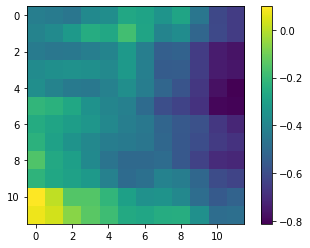

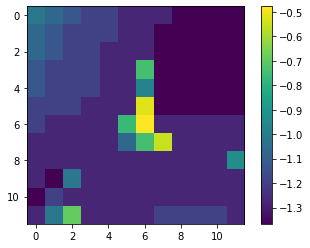

In [16]:

plt.imshow(x_decoded[0][0][0][10:-10,10:-10])
plt.colorbar()
plt.show()
plt.imshow(x[0][0][0][0][10:-10,10:-10])
plt.colorbar()
plt.show()